In [9]:
import pandas as pd
import glob
import os
import ast

# ==========================================
# 1. SETUP & DATA
# ==========================================
# df = pd.read_csv('your_file.csv') 
# ------------------------------------------------------------
 


og_df = pd.read_csv("all-MPU.csv")
# og_df = pd.read_csv(file)
df = og_df

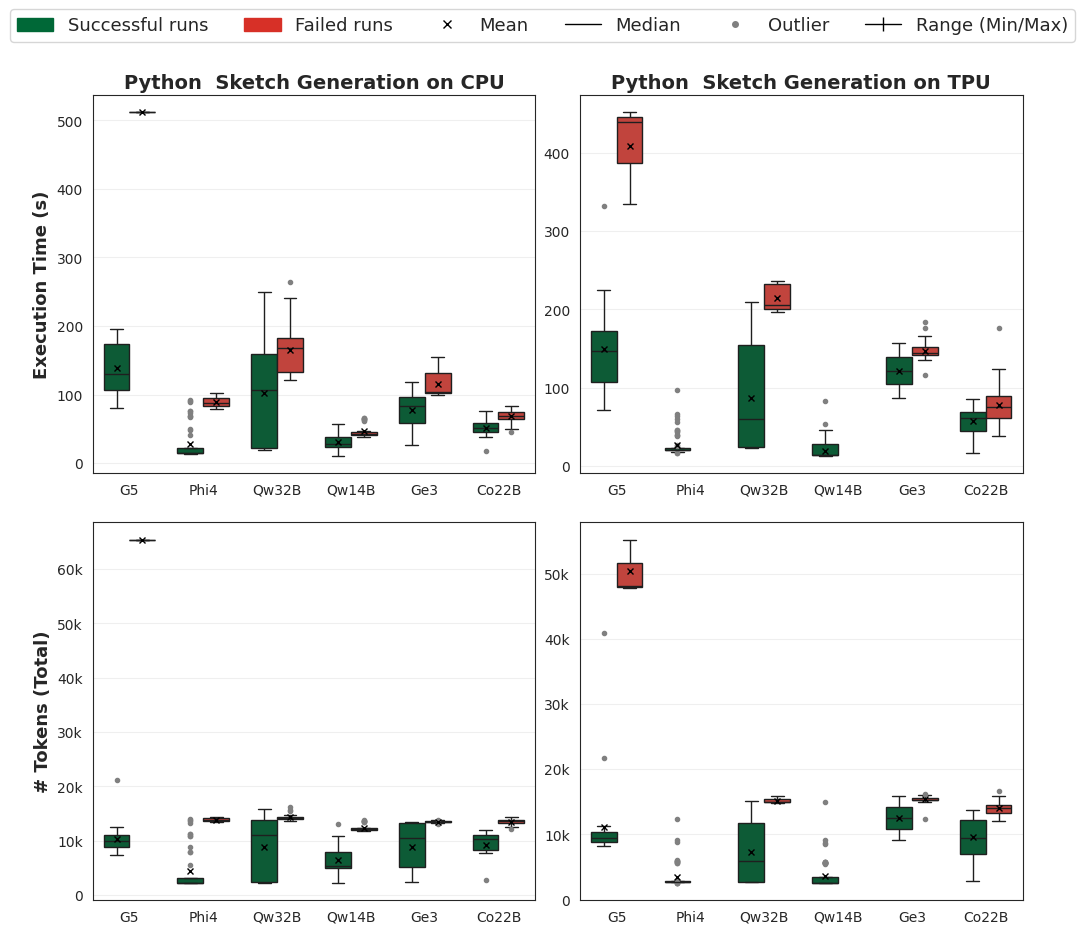

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D  # <--- Added for custom legend handles

# ==========================================
# 2. CONFIGURATION
# ==========================================
# Mappings
 


# Canonical labels and ordering (single source of truth)
MODEL_LABELS = {
    "gpt-5": "G5",
    "gpt-4o": "G4o",
    "gpt-4o-mini": "G4o-m",
    "phi4": "Phi4",
    "qwen32": "Qw32B",
    "qwen14": "Qw14B",
    "gemma3": "Ge3",
    "codestral": "Co22B",
    "codestral-p": "Co22B-p",
    
}
proc_titles = {
    'dp': 'Data Processing', 'mc': 'Model Conversion', 'sg': 'Arduino Sketch Generation', "psg": "Python  Sketch Generation on CPU", 
                    "tpusg": "Python  Sketch Generation on TPU",}

PROCESSOR_LABELS = { "dp": "DP",
                    "mc": "MC",  
                    "sg": "ArdSG",
                    "psg": "PySG-CPU", 
                    "tpusg": "PySG-TPU",}


# Ordering & Styling
MODEL_ORDER_PREF = list(MODEL_LABELS.keys())


PROCESSOR_ORDER_PREF = list(PROCESSOR_LABELS.keys())

# Filter to only processors that exist in the data
processors_in_data = [p for p in PROCESSOR_ORDER_PREF if p in df['processor'].unique()]
num_processors = len(processors_in_data)

# Filter to only models that exist in the data and map to display names
models_in_data = [m for m in MODEL_ORDER_PREF if m in df['model'].unique()]
model_display_order = [MODEL_LABELS[m] for m in models_in_data]
 
palette      = {'success': '#006837', 'failure': '#D73027'}

# Apply Map
df['model_display'] = df['model'].map(MODEL_LABELS)

# Metric Configuration
metrics = [
    {'col': 'latency',      'label': 'Execution Time (s)', 'fmt': None},
    {'col': 'total_tokens', 'label': '# Tokens (Total)',   'fmt': lambda x, p: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}'}
]

# ==========================================
# 3. PLOTTING
# ==========================================
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

fig, axes = plt.subplots(nrows=2, ncols=num_processors, figsize=(6*num_processors, 10))
plt.subplots_adjust(top=0.915, hspace=0.13, wspace=0.1) # Adjusted top to fit larger legend

for col_idx, proc in enumerate(processors_in_data):
    subset = df[df['processor'] == proc]
    
    for row_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        
        if subset.empty:
            ax.set_visible(False)
            continue

        # 1. Plot
        sns.boxplot(
            data=subset, x='model_display', y=metric['col'], hue='status',
            hue_order=['success', 'failure'], order=model_display_order,
            ax=ax, palette=palette,
            showmeans=True, 
            meanprops={"marker":"x", "markeredgecolor":"black", "markersize":5},
            flierprops={"marker":"o", "markersize":3, "markerfacecolor":"gray", "markeredgecolor":"gray"}, # Explicit styling for legend matching
            width=0.7, linewidth=1.0
        )
        
        # 2. Clean up
        if ax.get_legend(): ax.get_legend().remove()
        ax.set_xlabel("")
        ax.grid(axis='y', alpha=0.3)
        
        # 3. Styling
        ax.set_ylabel(metric['label'] if col_idx == 0 else "", fontweight='bold', fontsize=13)
        if row_idx == 0:
            ax.set_title(proc_titles.get(proc, proc), fontsize=14,  weight='bold', pad=5)
        if metric['fmt']:
            ax.yaxis.set_major_formatter(FuncFormatter(metric['fmt']))

# ==========================================
# 4. CUSTOM LEGEND
# ==========================================
# Define Custom Legend Elements
# A. Status Rectangles
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=palette['success'], label='Successful runs'),
    plt.Rectangle((0,0), 1, 1, color=palette['failure'], label='Failed runs'),
]

# B. Statistical Markers (Matching plot props)
legend_elements += [
    Line2D([0], [0], color='black', marker='x', linestyle='None', 
           markersize=6, label='Mean'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           label='Median'), # Default seaborn median line is dark grey/black
    Line2D([0], [0], color='gray', marker='o', linestyle='None', 
           markersize=4, label='Outlier'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           marker='|', markersize=10, label='Range (Min/Max)')
]
# ax.tick_params(axis='both', labelpad=0)  # or axis='x' or axis='y' separately

# Create the Legend
fig.legend(handles=legend_elements, loc='upper center', ncol=6, 
           bbox_to_anchor=(0.5, 1.01), fontsize=13, frameon=True)
plt.savefig("figs/box_MPU.pdf", dpi=300, bbox_inches='tight')
plt.savefig("figs/box_MPU.png", dpi=300, bbox_inches='tight')

plt.show()


In [11]:
# ==========================================
# EXPORT BOX PLOT STATISTICS
# ==========================================
# Calculate all statistics used in box plots for direct reproduction

def calculate_boxplot_stats(group_data):
    """Calculate all box plot statistics for a group"""
    if len(group_data) == 0:
        return {
            'count': 0,
            'min': None,
            'q1': None,
            'median': None,
            'q3': None,
            'max': None,
            'mean': None,
            'iqr': None,
            'lower_whisker': None,
            'upper_whisker': None,
            'outliers': None,
            'n_outliers': 0
        }
    
    q1 = group_data.quantile(0.25)
    q3 = group_data.quantile(0.75)
    iqr = q3 - q1
    
    # Calculate whiskers (1.5 * IQR rule used by matplotlib/seaborn)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Actual whisker positions (min/max within bounds)
    within_bounds = group_data[(group_data >= lower_bound) & (group_data <= upper_bound)]
    lower_whisker = within_bounds.min() if len(within_bounds) > 0 else group_data.min()
    upper_whisker = within_bounds.max() if len(within_bounds) > 0 else group_data.max()
    
    # Outliers (outside whisker bounds)
    outliers = group_data[(group_data < lower_bound) | (group_data > upper_bound)]
    
    return {
        'count': len(group_data),
        'min': group_data.min(),
        'q1': q1,
        'median': group_data.median(),
        'q3': q3,
        'max': group_data.max(),
        'mean': group_data.mean(),
        'iqr': iqr,
        'lower_whisker': lower_whisker,
        'upper_whisker': upper_whisker,
        'outliers': outliers.tolist(),
        'n_outliers': len(outliers)
    }

# Initialize list to store all statistics
all_stats = []

# Calculate statistics for each metric
metrics_to_export = [
    {'col': 'latency', 'label': 'Execution Time (s)'},
    {'col': 'total_tokens', 'label': '# Tokens (Total)'}
]

for metric in metrics_to_export:
    metric_col = metric['col']
    metric_label = metric['label']
    
    # Group by processor, model, and status
    for processor in df['processor'].unique():
        for model in df['model'].unique():
            for status in ['success', 'failure']:
                # Filter data for this combination
                subset = df[
                    (df['processor'] == processor) & 
                    (df['model'] == model) & 
                    (df['status'] == status)
                ][metric_col].dropna()
                
                # Calculate statistics
                stats = calculate_boxplot_stats(subset)
                
                # Add grouping information
                stats_record = {
                    'metric': metric_col,
                    'processor': processor,
                    'processor_label': PROCESSOR_LABELS.get(processor, processor),
                    'model': model,
                    'model_label': MODEL_LABELS.get(model, model),
                    'status': status,
                    **stats
                }
                
                all_stats.append(stats_record)

# Create DataFrame from statistics
stats_df = pd.DataFrame(all_stats)

# Filter out rows with no data
stats_df = stats_df[stats_df['count'] > 0]

# Drop outliers column for cleaner CSV
stats_df_clean = stats_df.drop(columns=['outliers'])

# Export to single CSV file
output_file = 'cost-time_statistics_MPU.csv'
stats_df_clean.to_csv(output_file, index=False)
print(f"✔ Exported all box plot statistics to: {output_file}")
print(f"  Total records: {len(stats_df_clean)}")
print(f"  Metrics included: latency, total_tokens")

# Display summary
print("\n" + "="*60)
print("STATISTICS SUMMARY")
print("="*60)
print(f"Metrics: {', '.join([m['col'] for m in metrics_to_export])}")
print(f"Processors: {', '.join(stats_df_clean['processor'].unique())}")
print(f"Models: {', '.join(stats_df_clean['model'].unique())}")
print(f"Status values: {', '.join(stats_df_clean['status'].unique())}")
print("\nColumns in exported CSV:")
for col in stats_df_clean.columns:
    print(f"  - {col}")
print("="*60)

# Display sample of statistics
print("\nSample statistics (first few rows):")
display(stats_df_clean.head(10))

✔ Exported all box plot statistics to: cost-time_statistics_MPU.csv
  Total records: 44
  Metrics included: latency, total_tokens

STATISTICS SUMMARY
Metrics: latency, total_tokens
Processors: psg, tpusg
Models: codestral, gemma3, gpt-5, phi4, qwen14, qwen32
Status values: success, failure

Columns in exported CSV:
  - metric
  - processor
  - processor_label
  - model
  - model_label
  - status
  - count
  - min
  - q1
  - median
  - q3
  - max
  - mean
  - iqr
  - lower_whisker
  - upper_whisker
  - n_outliers

Sample statistics (first few rows):


,metric,processor,processor_label,model,model_label,status,count,min,q1,median,q3,max,mean,iqr,lower_whisker,upper_whisker,n_outliers
0,latency,psg,PySG-CPU,codestral,Co22B,success,11,18.22,45.9350,51.400,58.4150,75.80,50.581818,12.4800,37.56,75.80,1
1,latency,psg,PySG-CPU,codestral,Co22B,failure,49,45.19,63.6900,68.960,74.6800,83.67,68.417347,10.9900,49.69,83.67,1
2,latency,psg,PySG-CPU,gemma3,Ge3,success,41,26.90,58.1000,83.570,96.7800,117.81,77.030732,38.6800,26.90,117.81,0
3,latency,psg,PySG-CPU,gemma3,Ge3,failure,19,98.97,102.1500,103.390,131.6950,155.17,115.396316,29.5450,98.97,155.17,0
4,latency,psg,PySG-CPU,gpt-5,G5,success,29,79.92,107.0100,130.610,173.8600,195.76,138.423103,66.8500,79.92,195.76,0
5,latency,psg,PySG-CPU,gpt-5,G5,failure,1,511.64,511.6400,511.640,511.6400,511.64,511.640000,0.0000,511.64,511.64,0
6,latency,psg,PySG-CPU,phi4,Phi4,success,48,13.72,13.9375,14.075,22.5300,91.50,28.139583,8.5925,13.72,16.60,12
7,latency,psg,PySG-CPU,phi4,Phi4,failure,12,79.14,83.9300,87.350,94.3525,102.67,89.165833,10.4225,79.14,102.67,0
8,latency,psg,PySG-CPU,qwen14,Qw14B,success,25,10.22,23.9100,27.390,38.2700,56.79,30.155200,14.3600,10.22,56.79,0
9,latency,psg,PySG-CPU,qwen14,Qw14B,failure,35,37.33,41.0550,42.300,44.6250,66.26,46.190571,3.5700,37.33,46.72,7
